In [23]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Carrega o dataset como dataframe
df = pd.read_csv('dataset/video_games_2016.csv')

In [25]:
# Remove outliers
Q1 = df['Global_Sales'].quantile(0.00)
Q3 = df['Global_Sales'].quantile(0.98)

df = df[(df['Global_Sales'] >= Q1 ) & (df['Global_Sales'] <= Q3 )]

In [26]:
# Cria coluna com a região que mais vendeu
column_to_number = {
    'NA_Sales':    "NA",
    'EU_Sales':    "EU",
    'JP_Sales':    "JP",
    'Other_Sales': "Outro" 
}

df['Greatest'] = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].idxmax(axis=1).map(column_to_number)


In [27]:
fdf = df.copy()
fdf["Platform_Code"] = fdf[ "Platform" ].astype("category").cat.codes

def reduce_platforms( l ):
    s = 0;
    for i in l:
        s |= 1 << i+1
    return s

grouped = fdf.groupby( "Name" )

grouped_df = grouped.agg(
    Genre=("Genre", "first"),
    Developer=("Developer", "first"),
    Greatest=("Greatest", "first"),
    Publisher=("Publisher", "first"),
    Year_of_Release=("Year_of_Release", "first"),
    Rating=("Rating", "first"),

    Count_Platforms=("Name", "count"),

    Platform_Codes=("Platform_Code", reduce_platforms),

    Global_Sales=("Global_Sales", "sum"),
    NA_Sales=("NA_Sales", "sum"),
    EU_Sales=("EU_Sales", "sum"),
    JP_Sales=("JP_Sales", "sum"),
    Other_Sales=("Other_Sales", "sum"),

    True_Score=("Critic_Score", "max"), 
    User_Score=("User_Score", "max"), 

    User_Count=("User_Count", "sum"), 
    Critic_Count=("Critic_Count", "sum"), 
    # True_Score=("Critic_Score", lambda x: (x * grouped["Critic_Count"].get_group(x.name)).sum() / grouped["Critic_Count"].get_group(x.name).sum()), 
    # Critic_Score=("Critic_Score", lambda x: x)
).reset_index()

grouped_df.sort_values("Count_Platforms", ascending=False).head(4)

,Name,Genre,Developer,Greatest,Publisher,Year_of_Release,Rating,Count_Platforms,Platform_Codes,Global_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales,True_Score,User_Score,User_Count,Critic_Count
6637,Need for Speed: Most Wanted,Racing,EA Canada,EU,Electronic Arts,2012.0,T,11,1881424288,9.40,4.20,3.88,0.10,1.22,83.0,9.1,1405.0,200.0
5088,LEGO Marvel Super Heroes,Action,TT Games,NA,Warner Bros. Interactive Entertainment,2013.0,E10+,9,2955690024,9.44,4.31,3.91,0.08,1.11,83.0,8.1,749.0,100.0
7680,Ratatouille,Action,Asobo Studio,EU,THQ,2007.0,E,9,672547232,4.41,2.03,1.35,0.00,0.99,65.0,8.0,50.0,65.0
1300,Cars,Racing,Rainbow Studios,NA,THQ,2006.0,E,8,1746010528,6.81,5.31,0.93,0.00,0.58,71.0,8.4,46.0,144.0


In [28]:
# ESCOLHA UM DELES:
# grouped_df: Dados agrupados
# df:         Dados normais

# gdf = grouped_df.copy()

gdf = df.copy()

m = gdf["Year_of_Release"].mean()
gdf["Year_of_Release"] = gdf["Year_of_Release"].fillna(m) 

# Transforma colunas categóricas em valores numéricos
# necessários para utilização de árvore de decisão
# e dropa os NA
cat = [
  "Publisher",
  "Platform",
  "Genre",
  "Developer",
  "Rating"
]

for c in cat: 
  gdf[c].dropna(inplace=True)
  gdf[c] = gdf[c].astype('category').cat.codes


In [29]:
# Campos que serão usados para classificação
campos = [
    # "Count_Platforms",
    "Publisher",
    "Platform", 
    "Genre",
    "Developer",
    "Rating",
    "Year_of_Release",
]

X = gdf[campos]

# Saída : NA | EU | JP | Outros
y = gdf['Greatest']

In [30]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Dividindo os conjuntos de treinamento e teste
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.3)


Score   :  0.976
Acurácia:  0.826 

Precisão:  [0.61118509 0.82882166 0.88569449 0.27272727]
Recall  :  [0.70506912 0.84703011 0.84837425 0.27272727]
F1-score:  [0.65477889 0.83782696 0.86663277 0.27272727]


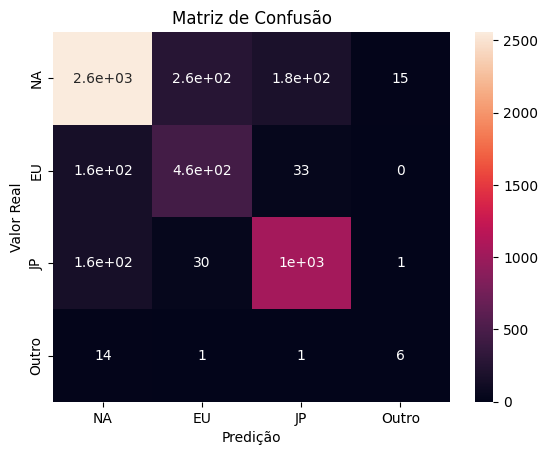

In [36]:
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.model_selection import GridSearchCV

labels = ["NA", "EU", "JP", "Outro"]

gbdc = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    random_state=0,
    min_samples_split=22,
    min_samples_leaf=10,
)

# param_grid = {
#     'n_estimators':      [ 800, 1000 ],        
#     'learning_rate':     [ 0.05, 0.1 ],    
#     'max_depth':         [ 5 ],
#     'min_samples_split': [ 10, 15 ],
#     'min_samples_leaf':  [ 5, 10],      
#     'subsample':         [ 0.8],              
#     'max_features':      ['sqrt', 'log2'] 
# }

# grid_search = GridSearchCV(
#   estimator=gbdc,
#   param_grid=param_grid, 
#   scoring='accuracy', 
#   cv=2, 
#   verbose=3, 
#   n_jobs=5
# )

# gbdc = grid_search

gbdc.fit(X_treinamento, y_treinamento, sample_weight=compute_sample_weight( class_weight='balanced', y=y_treinamento ))
y_pred = gbdc.predict(X_teste) 

accuracy = accuracy_score(y_teste, y_pred)

print("Score   : ", round(gbdc.score(X_treinamento, y_treinamento), 3) ) 
print("Acurácia: ", round(metrics.accuracy_score(y_teste, y_pred), 3), "\n")
print("Precisão: ", metrics.precision_score(y_teste, y_pred, average=None))
print("Recall  : ", metrics.recall_score(y_teste, y_pred, average=None))
print("F1-score: ", metrics.f1_score(y_teste, y_pred, average=None))

labels = ["NA", "EU", "JP", "Outro"]

matrizconfusao = metrics.confusion_matrix(y_teste, y_pred, labels=labels)

ax = plt.subplot()

sns.heatmap(matrizconfusao, annot=True, ax = ax);

ax.set_xlabel('Predição');
ax.set_ylabel('Valor Real'); 
ax.set_title('Matriz de Confusão'); 
ax.xaxis.set_ticklabels( labels ); 
ax.yaxis.set_ticklabels( labels ); 

In [ ]:
# Campos que serão usados para classificação
campos = [
    "Publisher",
    # "Platform", 
    "Genre",
    "Developer",
    "Rating",
    "Year_of_Release",
]

X = gdf[campos]

# Saída : NA | EU | JP | Outros
y = gdf['Greatest']

In [ ]:
modeloarvoredecisao = tree.DecisionTreeClassifier(
  criterion='entropy',
  class_weight="balanced"
)     

modeloarvoredecisao.fit(X_treinamento, y_treinamento)

y_predicao = modeloarvoredecisao.predict(X_teste)

print("Score   : ", round(modeloarvoredecisao.score(X_treinamento, y_treinamento), 3) ) 
print("Acurácia: ", round(metrics.accuracy_score(y_teste, y_predicao), 3), "\n")
print("Precisão: ", metrics.precision_score(y_teste, y_predicao, average=None))
print("Recall  : ", metrics.recall_score(y_teste, y_predicao, average=None))
print("F1-score: ", metrics.f1_score(y_teste, y_predicao, average=None))

Score   :  0.971
Acurácia:  0.71 

Precisão:  [0.36363636 0.73707274 0.77038627 0.28571429]
Recall  :  [0.36363636 0.75902527 0.75938657 0.15384615]
F1-score:  [0.36363636 0.74788795 0.76484687 0.2       ]


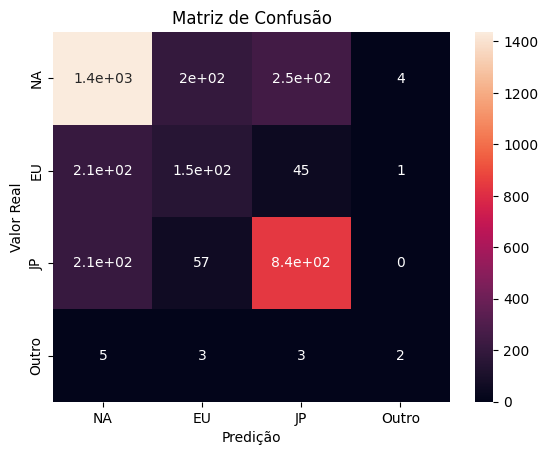

In [ ]:
labels = ["NA", "EU", "JP", "Outro"]

matrizconfusao = metrics.confusion_matrix(y_teste, y_predicao, labels=labels)

ax = plt.subplot()

sns.heatmap(matrizconfusao, annot=True, ax = ax);

ax.set_xlabel('Predição');
ax.set_ylabel('Valor Real'); 
ax.set_title('Matriz de Confusão'); 
ax.xaxis.set_ticklabels( labels ); 
ax.yaxis.set_ticklabels( labels );